In [1]:
import os
import csv
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re
import pyarabic.araby as araby
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense
from keras.optimizers import Adam
from nltk.stem import ISRIStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\karam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def remove_stop_words(text):
    arabic_stopwords = set(stopwords.words('arabic'))
    words = text.split()
    filtered_words = [word for word in words if word not in arabic_stopwords]
    return ' '.join(filtered_words)

def arabic_stemmer(text):
        Arabic_Stemmer = ISRIStemmer()
        text = [Arabic_Stemmer.stem(y) for y in text.split()]
        return " ".join(text)

def normalize_arabic(text):
    text = text.strip()
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("[إأٱآا]", "ا", text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('ييي', 'ي')
    text = text.replace('اا', 'ا')
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) 
    text = araby.strip_tashkeel(text)
    text = araby.strip_diacritics(text)
    text=''.join([i for i in text if not i.isdigit()])
    return text

def clean_text(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    text = re.sub('[A-Za-z]+',' ',text)
    text = ''.join([i for i in text if not i.isdigit()])
    return text.strip()

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_extra_Space(text):
    text = re.sub('\s+', ' ', text)
    return  " ".join(text.split())

archive_folder = 'C:\\Path\\to\\data'
output_csv = 'all_topics_numbered.csv'

with open(output_csv, mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.writer(csv_file)
    
    writer.writerow(['Filename', 'Content', 'Topic'])
    
    texts = []
    categories = []
    
    for folder_name in os.listdir(archive_folder):
        folder_path = os.path.join(archive_folder, folder_name)
        
        if os.path.isdir(folder_path):
            topic = folder_name  
            
            for txt_file in os.listdir(folder_path):
                if txt_file.endswith('.txt'):
                    txt_path = os.path.join(folder_path, txt_file)
                    
                    with open(txt_path, 'r', encoding='utf-8') as file:
                        content = file.read()
                    
                        content = remove_urls(content)
                        content = clean_text(content)
                        content = remove_stop_words(content)
                        content = normalize_arabic(content)
                        content = remove_extra_Space(content)
                        content = arabic_stemmer(content)
                        tokenizer = nltk.RegexpTokenizer(r"\w+")
                        content = tokenizer.tokenize(content)
                        
                        writer.writerow([txt_file, content, topic])
                        
                        texts.append(content)
                        categories.append(topic)

print(f"Successfully cataloged all files into {output_csv}")

df = pd.read_csv(output_csv)

# Drop the 'Filename' column
df = df.drop(df.columns[0], axis=1)

df.drop_duplicates(subset='Content', inplace=True)

df = df[df['Topic'] != 'Tech']

Successfully cataloged all files into all_topics_numbered.csv


In [3]:
# Read the CSV file using pandas
df = pd.read_csv(output_csv, error_bad_lines=False)

df = df.drop(df.columns[0], axis=1)

print(df.head())

C:\Users\karam\AppData\Local\Temp\ipykernel_20636\2394818531.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(output_csv, error_bad_lines=False)


                                             Content    Topic
0  ['نظم', 'عهد', 'شرق', 'فنن', 'عرض', 'فنا', 'عن...  Culture
1  ['تقم', 'فنن', 'ليت', 'كابيلو', 'عرض', 'طلع', ...  Culture
2  ['وصل', 'ليل', 'سير', 'تحد', 'تعه', 'ثره', 'ضم...  Culture
3  ['عقد', 'ظهر', 'اول', 'قصر', 'ثقف', 'شرق', 'جل...  Culture
4  ['خار', 'صحف', 'التايمز', 'جورج', 'رول', 'يحل'...  Culture


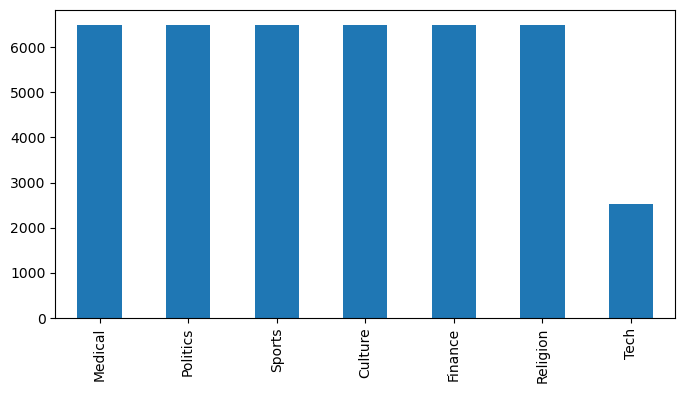

Medical     6500
Politics    6499
Sports      6499
Culture     6495
Finance     6495
Religion    6488
Tech        2516
Name: Topic, dtype: int64
Updated dataset topic distribution:
Medical     6500
Politics    6499
Sports      6499
Culture     6495
Finance     6495
Religion    6488
Name: Topic, dtype: int64


In [4]:
# Remove duplicates based on the 'Content' column
df.drop_duplicates(subset='Content', inplace=True)

# Set figure size
plt.figure(figsize=(8, 4))

# Create a bar plot for the value counts in 'label' column using pandas
df['Topic'].value_counts().plot(kind='bar')

# Display the plot to check if dataset is balanced
plt.show()
# Assuming df is the DataFrame that contains your data
print(df['Topic'].value_counts())

# Filter out the rows where the 'Topic' column has the value 'tech' since it is unbalanced
df = df[df['Topic'] != 'Tech']

# Verify that the 'Tech' topic is removed and duplicates are dropped
print("Updated dataset topic distribution:")
print(df['Topic'].value_counts())



In [5]:
# Apply the preprocessing functions to the text data
df['Content'] = df['Content'].apply(remove_urls)
df['Content'] = df['Content'].apply(clean_text)
df['Content'] = df['Content'].apply(remove_stop_words)
df['Content'] = df['Content'].apply(normalize_arabic)
df['Content'] = df['Content'].apply(remove_extra_Space)
df['Content'] = df['Content'].apply(arabic_stemmer)

# Print the preprocessed text data
print(df['Content'])

0        نظم عهد شرق فنن عرض فنا عنو بقه الف وذل سعه ال...
1        تقم فنن كابيلو عرض طلع عام دبي يضم عرض لوح ركز...
2        وصل ليل سير تحد تعه ثره ضمن يرق لقب شعر ملي نس...
3        عقد ظهر اول قصر ثقف شرق جلس ثني اخر جلس لقي او...
4        خار صحف يمز جورج رول يحل ربه ثني قءم تضم عظم ك...
                               ...                        
38995    قدم ندي شتوتغارت الم لعب جدد وهم دفع فنو يلز ل...
38996    قاد ثنء است فيل دار بنت وشل ونغ نخب جلتر فوز ع...
38997    ناي فيس ديل بوس درب نخب سبن جري ربل ومس وقل ءم...
38998    قال ايف كوريتخ دير عمل لعب خضرم شفي هيرنانديز ...
38999    فاز اسب رافايل ادل صنف حمل لقب اوزبكستا دينيس ...
Name: Content, Length: 38976, dtype: object


In [6]:
os.makedirs("Models", exist_ok=True)


w2v_params = {
    "vector_size": 300,    
    "window": 5,     
    "min_count": 5,  
    "workers": 7     
}

cnn_params = {
    "embedding_size": w2v_params["vector_size"],
    "filter_sizes": [3, 4, 5],
    "num_filters": 128,
    "dropout_rate": 0.5,
    "hidden_units": 64,
    "batch_size": 100,
    "epochs": 5,
    "patience": 3
}

train_texts, test_texts, train_topic, test_topic = train_test_split(df['Content'], df['Topic'], test_size=0.2, random_state=123)

w2v_model = Word2Vec(sentences=train_texts, **w2v_params)
w2v_model.save("Models/word2vec.model")


w2v_model = Word2Vec(sentences=train_texts, **w2v_params)
w2v_model.save("Models/word2vec.model")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

max_sequence_length = max([len(sequence) for sequence in train_sequences])
train_data = pad_sequences(train_sequences, maxlen=max_sequence_length, padding="post")
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length, padding="post")

topic_to_index = {topic: index for index, topic in enumerate(set(df['Topic']))}
train_topic = [topic_to_index[topic] for topic in train_topic]
test_topic = [topic_to_index[topic] for topic in test_topic]
train_topic = np.eye(len(topic_to_index))[train_topic]
test_topic = np.eye(len(topic_to_index))[test_topic]

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=cnn_params["embedding_size"]))
model.add(Conv1D(cnn_params["num_filters"], cnn_params["filter_sizes"][0], activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dropout(cnn_params["dropout_rate"]))
model.add(Dense(len(topic_to_index), activation="softmax"))  # Change the number of units to match the number of classes

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy", "precision", "recall"])

early_stopping = EarlyStopping(monitor="val_loss", patience=cnn_params["patience"], mode="min", restore_best_weights=True)
model_checkpoint = ModelCheckpoint("Models/cnn_model.keras", monitor="val_loss", mode="min", save_best_only=True)
history = model.fit(train_data, train_topic, batch_size=cnn_params["batch_size"], epochs=cnn_params["epochs"], callbacks=[early_stopping, model_checkpoint], validation_split=0.2)

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data, test_topic, batch_size=cnn_params["batch_size"])
test_predictions = model.predict(test_data)
test_predictions = np.argmax(test_predictions, axis=1)
test_topic = np.argmax(test_topic, axis=1)

print("Test accuracy:", test_accuracy)
print("Test precision:", precision_score(test_topic, test_predictions, average="macro"))
print("Test recall:", recall_score(test_topic, test_predictions, average="macro"))

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1095s 4s/step - accuracy: 0.7013 - loss: 0.9313 - precision: 0.8930 - recall: 0.4509 - val_accuracy: 0.9562 - val_loss: 0.1406 - val_precision: 0.9679 - val_recall: 0.9418
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1377s 6s/step - accuracy: 0.9445 - loss: 0.1795 - precision: 0.9565 - recall: 0.9331 - val_accuracy: 0.9703 - val_loss: 0.0976 - val_precision: 0.9767 - val_recall: 0.9620
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1329s 5s/step - accuracy: 0.9648 - loss: 0.1100 - precision: 0.9717 - recall: 0.9585 - val_accuracy: 0.9721 - val_loss: 0.0858 - val_precision: 0.9789 - val_recall: 0.9671
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1366s 5s/step - accuracy: 0.9786 - loss: 0.0731 - precision: 0.9824 - recall: 0.9745 - val_accuracy: 0.9737 - val_loss: 0.0805 - val_precision: 0.9785 - val_recall: 0.9695
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 962s 4s/step - accuracy: 0.9867 - loss: 0.0466 - precision: 0.9889 - recall: 0.9840 - val_accuracy: 0.9759 - val_loss

In [7]:
model.save("Models/cnn_model.keras")